# Data Preprocessing


## Import and Costants

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import imutils
import splitfolders
import random
from tqdm import tqdm
from google.colab import drive

## Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

## Download of the dataset

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/C-NMC_training_data.zip" -d "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset"


Before creating the data splits, we need to consolidate the training dataset, which is currently spread across three directories, into a single folder.

In [ ]:
#DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset/C-NMC_training_data"
#CLASSES = ['all', 'hem']
total_cells = 0
for label in CLASSES:
  #path
  fold0_path = DATA_DIR + '/fold_0/' + label
  fold1_path = DATA_DIR + '/fold_1/' + label
  fold2_path = DATA_DIR + '/fold_2/' + label
  new_path = DATA_DIR + '/' + label

  os.mkdir(new_path)
  #files
  fold0_files = os.listdir(fold0_path)
  fold1_files = os.listdir(fold1_path)
  fold2_files = os.listdir(fold2_path)

  total_files = 0
  total_files = len(fold0_files) + len(fold1_files) + len(fold2_files)
  total_cells += total_files

  print(label)
  print("Images of " + label + " cells: " + str(total_files))

  #moving files in the new directory
  for f in fold0_files:
    os.rename(fold0_path + '/' + f, new_path + '/' + f)
  for f in fold1_files:
    os.rename(fold1_path + '/' + f, new_path + '/' + f)
  for f in fold2_files:
    os.rename(fold2_path + '/' + f, new_path + '/' + f)

  os.rmdir(fold0_path)
  os.rmdir(fold1_path)
  os.rmdir(fold2_path)

os.rmdir(DATA_DIR + '/fold_0')
os.rmdir(DATA_DIR + '/fold_1')
os.rmdir(DATA_DIR + '/fold_2')

all
Images of all cells: 7272
hem
Images of hem cells: 3389


In [ ]:
all_cells = os.listdir(DATA_DIR + '/all')
hem_cells = os.listdir(DATA_DIR + '/hem')

cells = all_cells + hem_cells
num_cells = len(cells)
print("Total number of images: " + str(num_cells))

Total number of images: 10661


We display the dataset's class distribution.



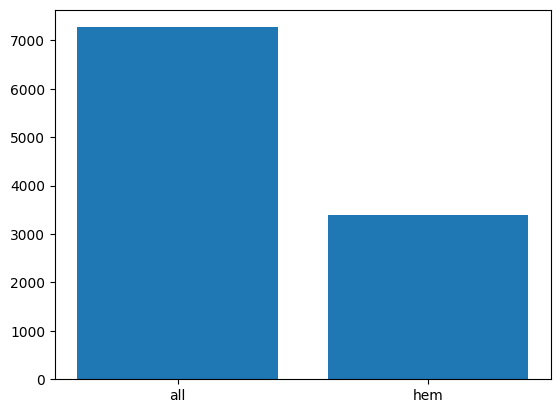

In [ ]:
num_per_classes = {}
for label in CLASSES:
  path = DATA_DIR + '/' + label
  num_per_classes[label] = len(os.listdir(path))

keys = list(num_per_classes.keys())
values = list(num_per_classes.values())

plt.bar(range(len(CLASSES)), values, tick_label=keys)
plt.show()


## Dataset loading
We will create Dataset objects from the sets directory using the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
random.seed(SEED) # seed is specified to always obtain the same results
training_set, validation_set, test_set = split_dataset(cells, num_cells)

num_training_samples = len(training_set)
num_validation_samples = len(validation_set)
num_test_samples = len(test_set)

print("Number of samples in the training set: " + str(num_training_samples))
print("Number of samples in the validation set: " + str(num_validation_samples))
print("Number of samples in the test set: " + str(num_test_samples))

Number of samples in the training set: 6396
Number of samples in the validation set: 2132
Number of samples in the test set: 2133


## Solving the Unbalanced Classes Issue
As indicated by the histogram below, there is an unequal distribution of images between the two classes.

Number of all cell images: 4373
Number of hem cell images: 2023


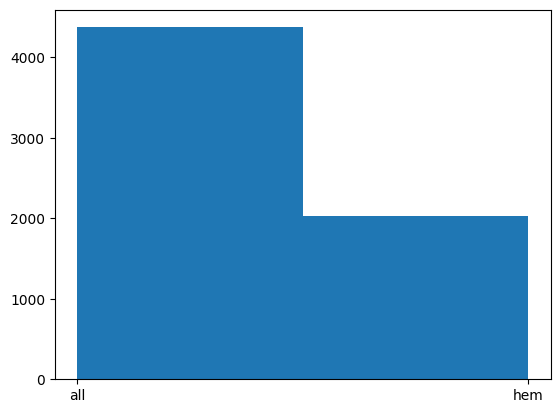

In [ ]:
all_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'all']
hem_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'hem']

labels = [entry.split(".")[0][-3:] for entry in training_set]
_ = plt.hist(labels, bins=2)

print("Number of all cell images: " + str(len(all_samples)))
print("Number of hem cell images: " + str(len(hem_samples)))

To address this imbalance, we aim to ensure that both classes have an equal number of images.

In [ ]:
expected_samples_per_class = num_training_samples//2
print("Number of expected images per class: " + str(expected_samples_per_class))

Number of expected images per class: 3198


To achieve balance, we'll perform a random sub-sampling of the largest class, which is the one representing cancer cells, to select the desired number of images.

In [ ]:
sampled_all = random.sample(all_samples, expected_samples_per_class)
print("Number of sampled cancer cell images: " + str(len(sampled_all)))

Number of sampled cancer cell images: 3198


For the smaller class, we'll employ data augmentation. To begin, we need to select a subset of images on which we will apply the augmentation.

In [ ]:
hem_samples_needed = expected_samples_per_class - len(hem_samples)
sampled_hem = random.sample(hem_samples, hem_samples_needed)
print("Number of sampled normal cell images to perform augmentation: " + str(len(sampled_hem)))
print("Final number of normal cell images: " + str(len(sampled_hem) + len(hem_samples)))

Number of sampled normal cell images to perform augmentation: 1175
Final number of normal cell images: 3198


## Data Preprocess
 Some examples of the images of the dataset are shown below.

Text(0.5, 1.0, '(450, 450, 3)')

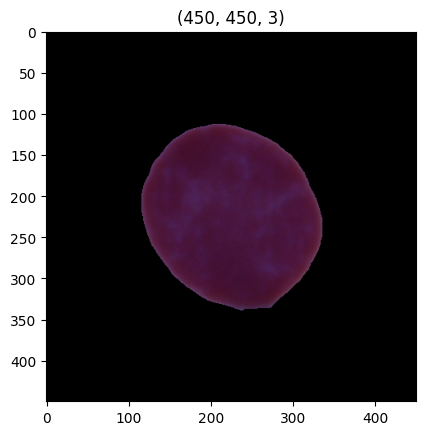

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset/C-NMC_training_data/all/UID_1_2_2_all.bmp'
img = cv2.imread(path)

plt.imshow(img)
plt.title(str(img.shape))

In [ ]:
def show_samples(num_samples, base_dir, data_augmentation=False):
  plt.figure(figsize=(10, 8))
  i = 0
  for label in CLASSES:
    path = base_dir + '/' + label
    for img_name in os.listdir(path):
      img = cv2.imread(path + "/" + img_name)
      if data_augmentation is not False:
        img = data_augmentation(img).numpy() / 255.0
        #img = data_augmentation(img).numpy()
      ax = plt.subplot(4, num_samples, i + 1)
      plt.imshow(img)
      plt.title(label)
      plt.axis("off")
      i += 1
      if i % num_samples == 0:
        break
  plt.show()

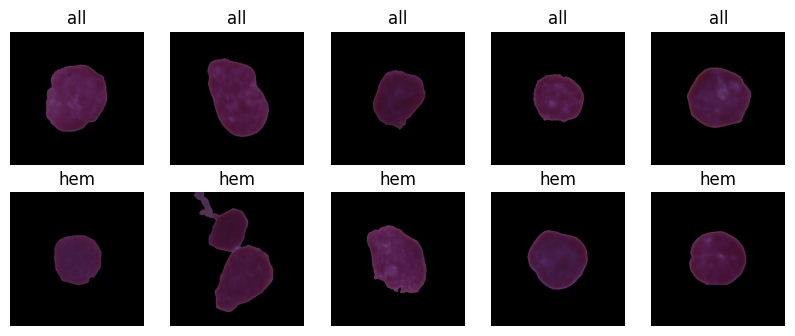

In [ ]:
show_samples(5, DATA_DIR)

Considering that the images contain a significant amount of background, our objective is to crop them in a way that minimizes the presence of any black outlines or borders.

In [ ]:
def crop_img(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        cnt = contours[0]
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image
    else:
        return None


Example of Center Cropping.


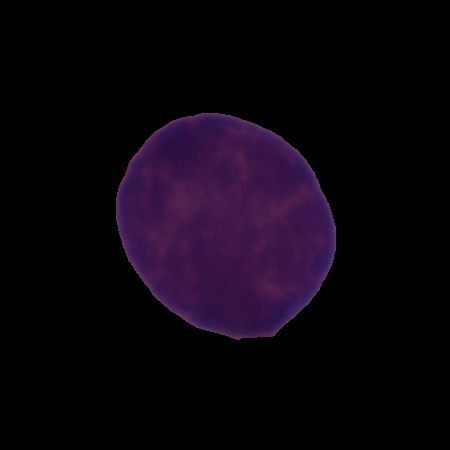

(450, 450, 3)


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset/C-NMC_training_data/all/UID_1_2_2_all.bmp'
img = cv2.imread(path)
cv2_imshow(img)
print(img.shape)

After the cropping process, the resulting image looks as follows.

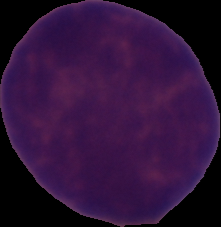

(227, 221, 3)

In [ ]:
cropped_image = crop_img(img)
cv2_imshow(cropped_image)
cropped_image.shape

Data rotation.

In [ ]:
def random_rotation(img):
  '''
  random_rotation randomly rotates the image
  :param original_image: the image on which to perform the transformation
  :return: the transformed image
  '''
  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(img)
    else:
      new_image = tf.image.flip_up_down(img)
  else: # rotate the image of a random degree (between 90° and 270°)
    k = random.randint(1,3)
    new_image = tf.image.rot90(img, k)

  return np.asarray(new_image)

Example of flips and rotations.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset/C-NMC_training_data/all/UID_1_2_2_all.bmp'
img = cv2.imread(path)
vertical_flip = tf.image.flip_up_down(img)
horizontal_flip = tf.image.flip_left_right(img)
rotation_90 = tf.image.rot90(img, k=1)
rotation_180 = tf.image.rot90(img, k=2)
rotation_270 = tf.image.rot90(img, k=3)

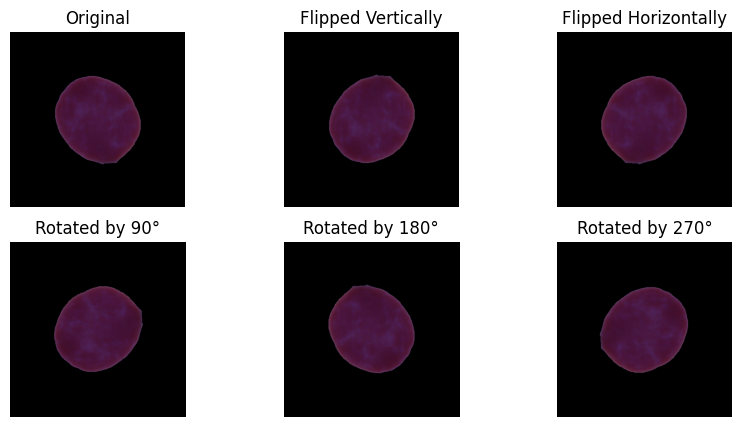

In [ ]:
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(2, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original")

fig.add_subplot(2, 3, 2)
plt.imshow(vertical_flip)
plt.axis('off')
plt.title("Flipped Vertically")

fig.add_subplot(2, 3, 3)
plt.imshow(horizontal_flip)
plt.axis('off')
plt.title("Flipped Horizontally")

fig.add_subplot(2, 3, 4)
plt.imshow(rotation_90)
plt.axis('off')
plt.title("Rotated by 90°")

fig.add_subplot(2, 3, 5)
plt.imshow(rotation_180)
plt.axis('off')
plt.title("Rotated by 180°")

fig.add_subplot(2, 3, 6)
plt.imshow(rotation_270)
plt.axis('off')
_ = plt.title("Rotated by 270°")

We will apply this function to crop the images and resize them to a uniform size. The new image size is set to 224 since it aligns with the standard input size of the pretrained Convolutional Neural Network we plan to use later.

In [ ]:
os.makedirs(PREPROCESSED_DIR + '/test_set/all')
os.makedirs(PREPROCESSED_DIR + '/test_set/hem')
os.makedirs(PREPROCESSED_DIR + '/validation_set/all')
os.makedirs(PREPROCESSED_DIR + '/validation_set/hem')
os.makedirs(PREPROCESSED_DIR + '/training_set/all')
os.makedirs(PREPROCESSED_DIR + '/training_set/hem')

In [ ]:
IMG_SIZE = 224
for sample in sampled_all: # store cropped cancer cell images
  img = cv2.imread(DATA_DIR + '/all/' + sample)
  new_img = crop_img(img)
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREPROCESSED_DIR + '/training_set/all/' + sample, new_img)

for sample in hem_samples: # store cropped normal cell images
  img = cv2.imread(DATA_DIR + '/hem/' + sample)
  new_img = crop_img(img)
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREPROCESSED_DIR + '/training_set/hem/' + sample, new_img)

for sample in sampled_hem: # store cropped normal cell augmented images
  img = cv2.imread(DATA_DIR + '/hem/' + sample)
  augmented_img = random_rotation(img)
  new_img = crop_img(augmented_img)
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREPROCESSED_DIR + '/training_set/hem/augmented_' + sample, new_img)

Validation set.

In [ ]:
for sample in validation_set: # store cropped validation set images
  label = sample.split(".")[0][-3:]
  img = cv2.imread(DATA_DIR + '/' + label + '/' + sample)
  new_img = crop_img(img)
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREPROCESSED_DIR + '/validation_set/' + label + '/' + sample, new_img)

Test set.

In [ ]:
for sample in test_set: # store cropped test set images
  label = sample.split(".")[0][-3:]
  img = cv2.imread(DATA_DIR + '/' + label + '/' + sample)
  new_img = crop_img(img)
  new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
  cv2.imwrite(PREPROCESSED_DIR + '/test_set/' + label + '/' + sample, new_img)

It's important to note that in the later stages, all the provided models will incorporate data augmentation techniques to combat overfitting. This augmentation will involve random changes to the horizontal and vertical orientation of the images, as well as adjustments to the contrast. The specific layers responsible for defining these transformations can be found in the "Utils.ipynb" notebook.

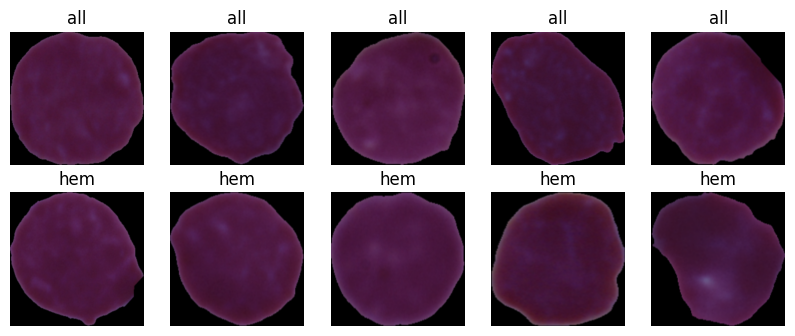

In [ ]:
show_samples(5, PREPROCESSED_DIR + '/training_set')

Here are some examples of images after undergoing transformations:

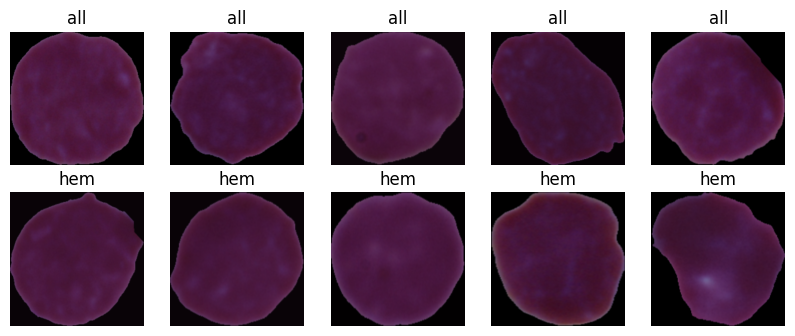

In [ ]:
show_samples(5, PREPROCESSED_DIR + '/training_set', data_augmentation_layers)

We will upload a zip file containing the data splits to the drive.

In [ ]:
%%capture
!zip -r "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned"